# A variational neural network-based solver for the metric conforming mesh generation

This prelimitary work is inspired from Prof. Maria K. Cameron's notebook "A variational neural network-based solver for the committor problem". For a PDE that can be expressed as a Euler-Lagrangian equation, its solution is identical to the minimizer of a calculous of variation problem. The commiter problem is formulated from the PDE, while our case is formulated from the variational problem. In out past works, we find the solution by solving the Euler-Lanrangian equation. But this approach has limitations: if we want to modify the misfit (the integrand of the functional), we need to put non-trivial effort to derive the new Euler-Lagrangian, find the diffusion coefficients and a correct discretization. Even worse, some reasonabel choices of misfit leads to Euler-Lagrangian that isn't uniformly elliptic and has singularities, which becomes impossible to be solved. Therefore, it worth to consider minimizing the variational problem directly. The easiest choice to try first is training a neural network as an approximation of $x(s)$ (or $s(x)$). 

Let $\mathcal{N}(s)=x$ be a $\mathbb{R}^2$ to $\mathbb{R}^2$ be a neural network,

We propose a solution model: 
$$x_1(s) = x_1^0(s) + s_1(1-s_1)\mathcal{N}_1(s)$$
$$x_2(s) = x_2^0(s) + s_2(1-s_2)\mathcal{N}_2(s)$$
Where $x_1^0(s)$ and $x_2^0(s)$ are the initial guess of the map from computational space to physical space. The quadratic coefficients s_1(1-s_1) and s_2(1-s_2) are here to strictly enforce Dirichlet boundary conditions: $x_1$ must equal to initial value where $s_1=0,1$, and $x_2$ must equal to initial value where $s_2=0,1$.

For now, a simple MLP is used as the neural network. 

The loss function is constructed as: $\mathcal{L} = \mathcal{L}_\text{int} + \mathcal{L}_\text{Neu}$. Where $\mathcal{L}_\text{int} = \frac{1}{N} \sum_k^N \sigma_1^2 M_{ij} x_{i,\alpha} x_{j,\alpha}$, the average of misfit values at grid points. And $\mathcal{L}_\text{Neu} = \text{Avg\_of\_North}(\partial_n x_1) + \text{Avg\_of\_South}(\partial_n x_1) + \text{Avg\_of\_West}(\partial_n x_2) + \text{Avg\_of\_East}(\partial_n x_2)$. The derivative of $x$ can be easily evaluated thanks to automatic differentiation.

In [47]:
import numpy as np
import torch
import matplotlib.pyplot as plt

from nn4mg import (
    build_boundary_data,
    extract_boundaries,
    init_model_weights,
    load_grid_csv,
    M_fun_torch,
    Model,
    plot_grid,
    train,
)

## Load grid data

Ensure `x1.csv` and `x2.csv` exist in the working directory (or update paths below).

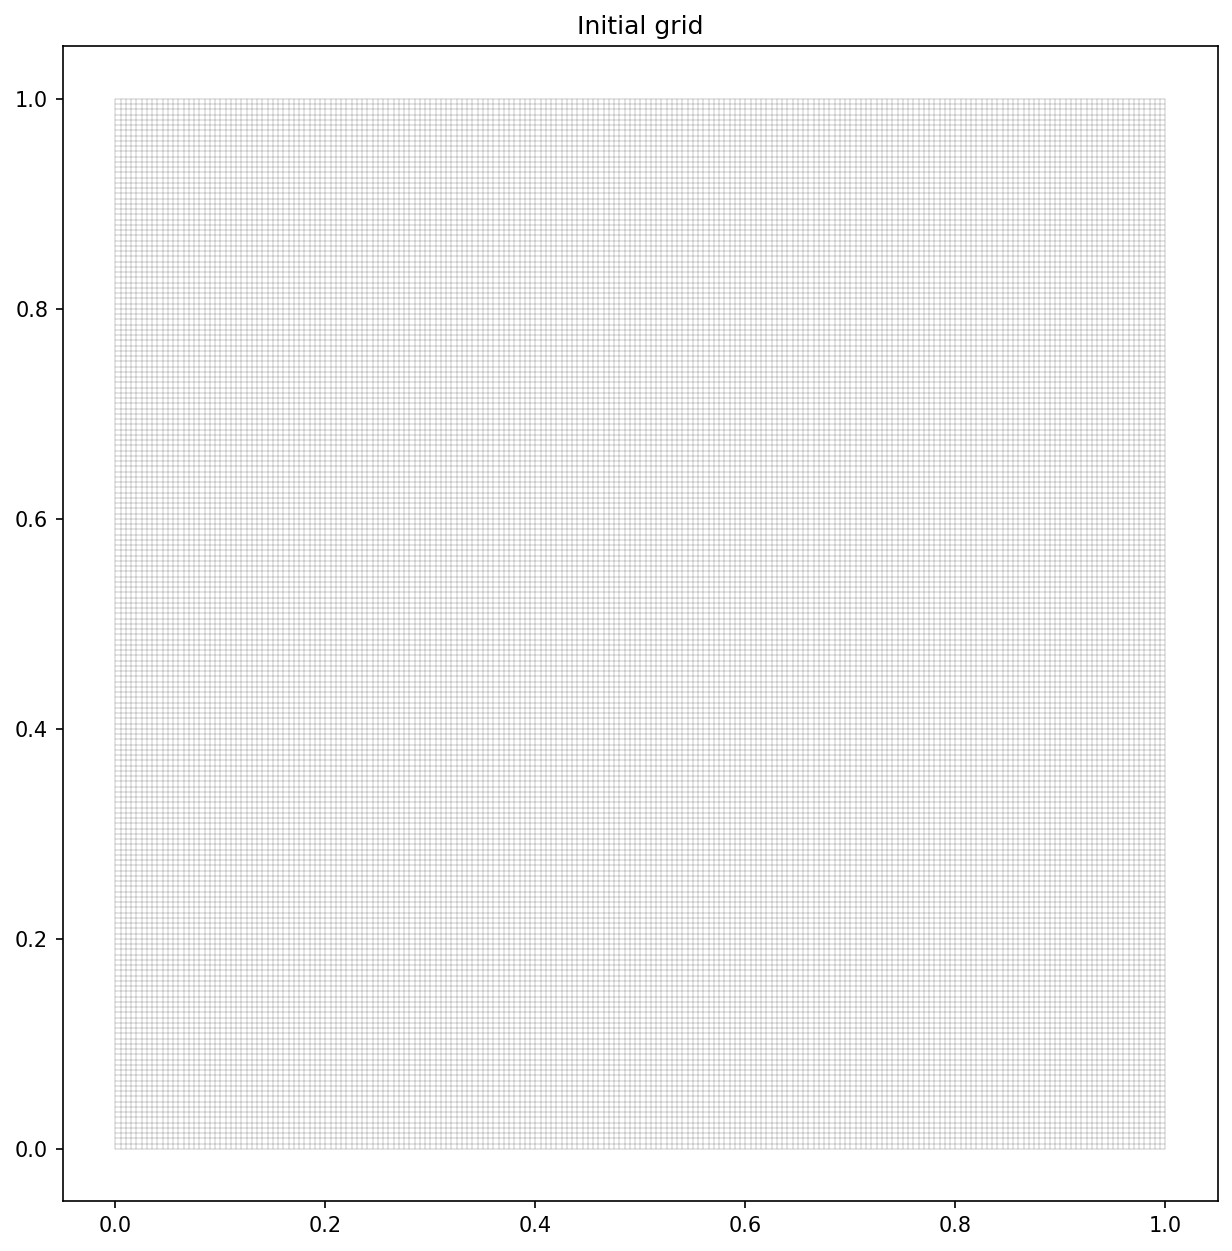

In [48]:
X1, X2 = load_grid_csv("x1.csv", "x2.csv")
Nx1, Nx2 = np.shape(X1)

fig, _ = plot_grid(X1, X2, title="Initial grid")
plt.show()

## Build boundary data and model

In [49]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
dtype = torch.float32

south_np, north_np, west_np, east_np = extract_boundaries(X1, X2)
boundary = build_boundary_data(
    south_np, north_np, west_np, east_np, device=device, dtype=dtype
)

net = Model(width=128, depth=4)
init_model_weights(net)

## Train

Set `plot_every` to 0 to disable training plots.

In [52]:
def M_fun_torch_selected(x1, x2):
    return M_fun_torch(x1, x2, problem=1)

net, best = train(
    net,
    X1,
    X2,
    boundary,
    M_fun_torch_selected,
    steps=20,
    N_bdry=256,
    lr=5e-4,
    plot_every=0,
    device=device,
    dtype=dtype,
)

step      1 | loss 4.5947e+07 | Lint 4.595e+07 Lbdry 1.227e+03 | 
step      2 | loss 4.4512e+07 | Lint 4.451e+07 Lbdry 1.841e+03 | 
step      3 | loss 4.2901e+07 | Lint 4.290e+07 Lbdry 2.778e+03 | 
step      4 | loss 4.1113e+07 | Lint 4.111e+07 Lbdry 3.844e+03 | 
step      5 | loss 3.9152e+07 | Lint 3.915e+07 Lbdry 5.300e+03 | 


KeyboardInterrupt: 

## Visualize final grid

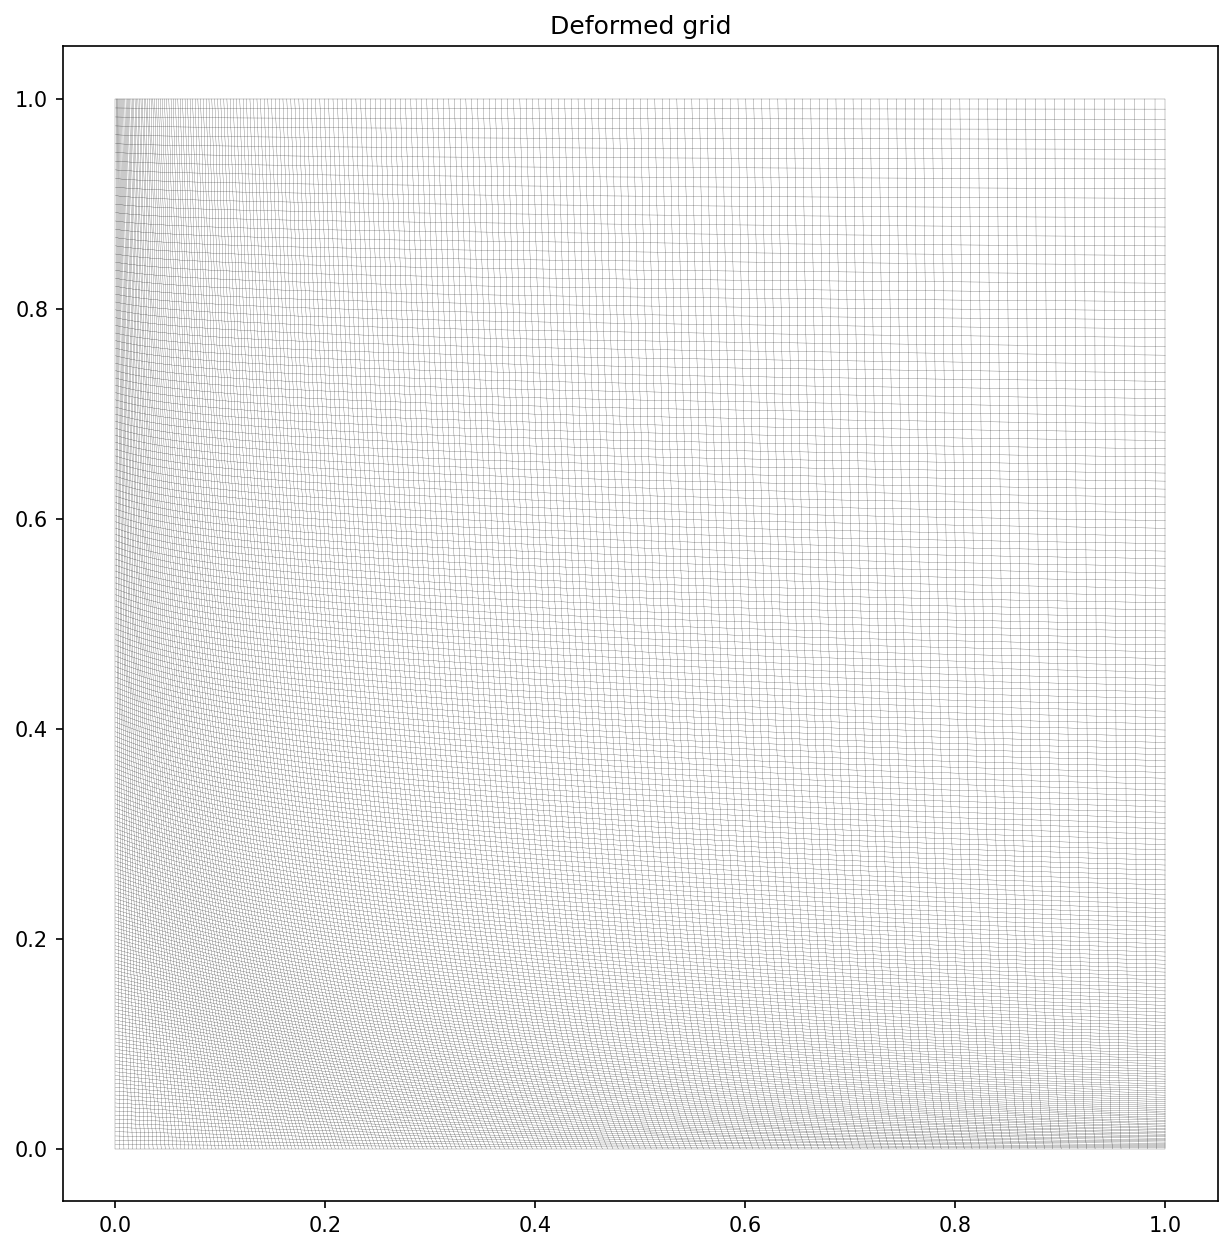

In [ ]:
xy_int = np.concatenate((X1.flatten().reshape(-1, 1), X2.flatten().reshape(-1, 1)), axis=1)
xy_int = torch.from_numpy(xy_int).float().to(device=device, dtype=dtype)

with torch.no_grad():
    out = net(xy_int)

X = torch.reshape(out[:, 0], (Nx2, Nx1)).detach().cpu().numpy()
Y = torch.reshape(out[:, 1], (Nx2, Nx1)).detach().cpu().numpy()

fig, _ = plot_grid(X, Y, title="Deformed grid")
plt.show()